In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

In [201]:
leads = pd.read_csv('./brazilian-ecommerce/olist_marketing_qualified_leads_dataset.csv',
                    parse_dates=['first_contact_date'])
closed = pd.read_csv('./brazilian-ecommerce/olist_closed_deals_dataset.csv')

# EDA

## First Contact

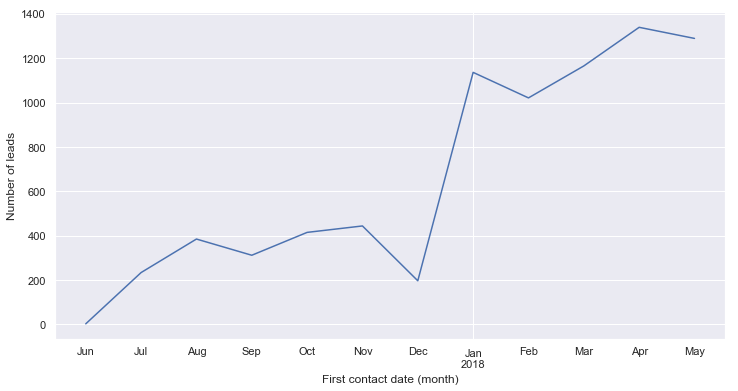

In [135]:
leads.set_index('first_contact_date')\
    .loc[:,'origin']\
    .resample('M')\
    .count()\
    .plot(figsize=(12,6));
plt.ylabel('Number of leads')
plt.xlabel('First contact date (month)');

In [136]:
test = leads.assign(dummy=1)\
            .pivot_table(columns='origin', index='first_contact_date', aggfunc='sum')\
            .fillna(0)\
            .resample('M')\
            .sum()

In [138]:
test.columns = test.columns.get_level_values(1)

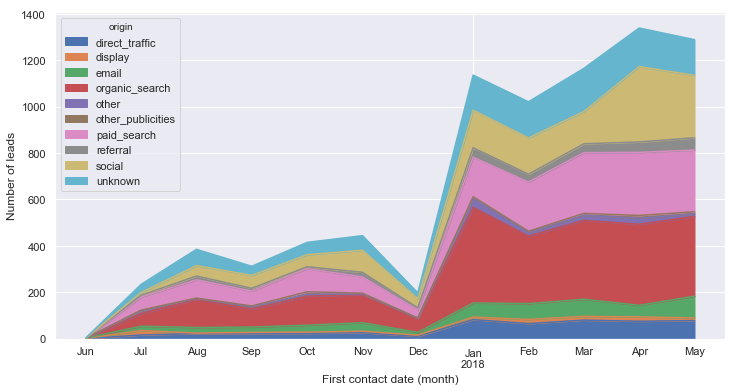

In [140]:
test.plot.area(figsize=(12,6));
plt.ylabel('Number of leads')
plt.xlabel('First contact date (month)');

## Landing Page

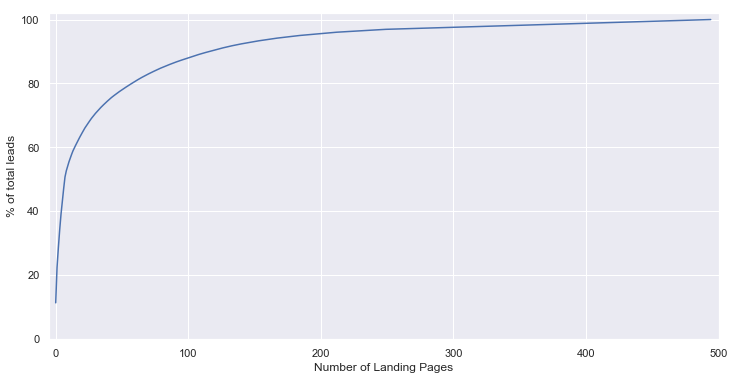

In [54]:
cumulative_pct_landing = leads.landing_page_id.value_counts(normalize=True).cumsum() *100
cumulative_pct_landing.reset_index(drop=True).plot.line(figsize=(12,6));
plt.xlabel('Number of Landing Pages')
plt.ylabel('% of total leads')
plt.xlim((-5,500))
plt.ylim((0,102));

## closed deals

Success rate of origins = number of closed / number of leads

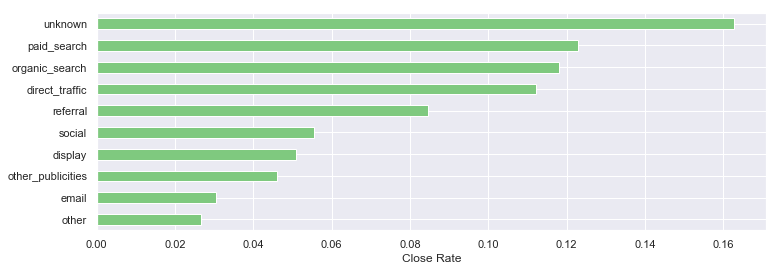

In [79]:
origin_success_rate = closed.merge(leads, how='left', on='mql_id')\
                            .origin.value_counts() / leads.origin.value_counts()
origin_success_rate.sort_values(ascending=True).plot.barh(figsize=(12,4), cmap='Accent')
plt.xlabel('Close Rate');

Find the best landing pages by their success (close) rate:

In [90]:
closed_landings = closed.merge(leads, how='left', on='mql_id')\
                        .landing_page_id.value_counts()
lead_landings = leads.landing_page_id.value_counts()

In [233]:
top_landings_byrate = pd.DataFrame({'num_closed': closed_landings,
                                    'rate_closed': closed_landings/lead_landings[closed_landings.index]})
# choose minimum number of closed merchants at 10 arbitrarily
top_landings_byrate.loc[top_landings_byrate.num_closed >= 10]\
                    .sort_values(by='rate_closed', ascending=False)

,num_closed,rate_closed
30077c17f2ec5010a82e37ad8925b95f,10,0.208333
40dec9f3d5259a3d2dbcdab2114fae47,67,0.203030
22c29808c4f815213303f8933030604c,174,0.197055
b76ef37428e6799c421989521c0e5077,171,0.187500
7fa6214d82e911d070f51ef79381b956,11,0.161765
ce1a65abd0973638f1c887a6efcfa82d,59,0.149746
241f79c7a8fe0270f4fb79fcbbcd17ad,14,0.128440
a7982125ff7aa3b2054c6e44f9d28522,18,0.115385
88740e65d5d6b056e0cda098e1ea6313,31,0.069663
f017be4dbf86243af5c1ebed0cff36a2,21,0.067742


These would be the top 12 landing pages that are recommended to focus on increasing the lead volume.

# Segmentation of leads

**Objective:** Identify merchants most likely to close, based on lead attributes.

**Method:** Use logistic regression to determine how each landing_page and origin affect closing.

In [202]:
leads.groupby('landing_page_id')['origin']\
     .apply(lambda x: len(set(x)))\
     .sort_values(ascending=False).head() # multiple origins per landing page

landing_page_id
b76ef37428e6799c421989521c0e5077    11
1722481ac9e5371e5099dea226b5421d    11
22c29808c4f815213303f8933030604c    11
e492ee5eaf1697716985cc6f33f9cd9b    10
88740e65d5d6b056e0cda098e1ea6313    10
Name: origin, dtype: int64

In [203]:
leads['month'] = leads.first_contact_date.dt.month
leads['dayofweek'] = leads.first_contact_date.dt.dayofweek # Monday=0, Sunday=6

In [204]:
leads = leads.merge(closed[["seller_id", "mql_id"]], "left", on="mql_id")
leads['closed'] = np.where(leads.seller_id.isna(), 0, 1)

In [241]:
leads = leads.drop(columns=['mql_id', 'first_contact_date', 'seller_id'])
leads.landing_page_id = leads.landing_page_id.where(leads.landing_page_id.isin(top_landings_byvol), 
                                                    'others')

In [331]:
X = pd.get_dummies(leads.drop(columns=['closed']),
                   columns=['landing_page_id', 'origin', 'dayofweek', 'month'],
                   drop_first=True)
y = leads['closed']

Build model:

In [231]:
import statsmodels.api as sm

In [332]:
X.columns[(X.corr() > 0.3).sum() > 1] # correlated features

Index(['landing_page_id_58326e62183c14b0c03085c33b9fdc44',
       'landing_page_id_73f31a40697cc90a86c1273563ac230e',
       'landing_page_id_88740e65d5d6b056e0cda098e1ea6313',
       'landing_page_id_b76ef37428e6799c421989521c0e5077', 'origin_other',
       'origin_social', 'origin_unknown'],
      dtype='object')

In [333]:
X = X.drop(columns=['landing_page_id_58326e62183c14b0c03085c33b9fdc44',
                    'landing_page_id_73f31a40697cc90a86c1273563ac230e',
                    'landing_page_id_88740e65d5d6b056e0cda098e1ea6313',
                    'landing_page_id_b76ef37428e6799c421989521c0e5077'])

In [334]:
X.columns[(X.corr() > 0.5).sum() > 1]

Index([], dtype='object')

In [374]:
model = sm.Logit(y, sm.tools.add_constant(X, prepend=True))

In [375]:
# grid search for best fit model using aic
best_alpha = 0
best_aic = 1e9
for a in np.logspace(0, 2, num=30):
    results = model.fit_regularized(disp=False, method='l1', alpha=a)
    if results.aic < best_aic:
        best_alpha = a
        best_aic = results.aic

In [376]:
best_aic, best_alpha

(4974.391485788783, 2.2122162910704493)

In [377]:
results = model.fit_regularized(disp=False, method='l1', alpha=2.2)
results.summary()

C:\Users\Hong Jie\Anaconda3\envs\python35\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Hong Jie\Anaconda3\envs\python35\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Hong Jie\Anaconda3\envs\python35\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 closed   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7960
Method:                           MLE   Df Model:                           39
Date:                Tue, 23 Apr 2019   Pseudo R-squ.:                 0.09090
Time:                        18:24:07   Log-Likelihood:                -2447.1
converged:                       True   LL-Null:                       -2691.7
                                        LLR p-value:                 3.303e-79
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                               -2.0905      0.140    -14.978      0.000      -2.364      -1.817
landing_page_id_0218f6be0b76aca72ab4d00ee9e8cf10          0        nan        nan        nan         nan         nan
landing_page_id_0b37d43dbde6452cdd94c17bf61a88e4    -0.2627      0.713     -0.369      0.712      -1.659       1.134
landing_page_id_15cf89bab2c3163b4f9d8601d108f8b2    -0.1429      0.595     -0.240      0.810      -1.308       1.023
landing_page_id_1722481ac9e5371e5099dea226b5421d          0        nan        nan        nan         nan         nan
landing_page_id_1ceb590cd1e00c7ee95220971f82693d          0        nan        nan        nan         nan         nan
landing_page_id_21a104c3279681d9856b8a48723c4fee          0        nan        nan        nan         nan         nan
landing_page_id_22c29808c4f815213303f8933030604c     0.7267      0.117      6.193      0.000       0.497       0.957
landing_page_id_241f79c7a8fe0270f4fb79fcbbcd17ad          0        nan        nan        nan         nan         nan
landing_page_id_27cd3540bace1f4a4b2bc6d319b0553c          0        nan        nan        nan         nan         nan
landing_page_id_30077c17f2ec5010a82e37ad8925b95f     0.5087      0.407      1.250      0.211      -0.289       1.307
landing_page_id_30534107aa0013db92899c96a1017d0b    -0.1178      0.706     -0.167      0.867      -1.501       1.266
landing_page_id_330b9d44078a1ae5a221d655dcb77afa    -0.0073      0.437     -0.017      0.987      -0.864       0.850
landing_page_id_35c9b150ab36fe584c1f24fd458c453a          0        nan        nan        nan         nan         nan
landing_page_id_36120633c8737035fbabf079082f4ec1    -0.6581      0.514     -1.281      0.200      -1.665       0.349
landing_page_id_3cd2a8301d5395f21cdd3094c9eaa2f4          0        nan        nan        nan         nan         nan
landing_page_id_40dec9f3d5259a3d2dbcdab2114fae47     0.5729      0.164      3.484      0.000       0.251       0.895
landing_page_id_4aab772aeb9833c170d8ea5413e02eac          0        nan        nan        nan         nan         nan
landing_page_id_4e82dd1f6d00626bda0723eef0a269a6          0        nan        nan        nan         nan         nan
landing_page_id_5dc848e7dd9418dffe183215b8ff0bc1          0        nan        nan        nan         nan         nan
landing_page_id_649b7b8b46b254497e92038d88f6ced8          0        nan        nan        nan         nan         nan
landing_page_id_65d9f9d71e562365e8b44037c2888d98    -0.3300      0.402     -0.821      0.412      -1.118       0.458
landing_page_id_73fec6021437e723ff5adae8dff89e23          0        nan        nan        nan         nan         nan
landing_page_id_7fa6214d82e911d070f51ef79381b956     0.3361      0.376      0.895      0.371      -0.400       1.072
landing_page_id_87732658ba41d8775e8577df347a64db          0        nan        nan 

Refit model with significant features only

In [379]:
X_trim = X.loc[:, (results.pvalues < 0.1)]
model_trim = sm.Logit(y, sm.add_constant(X_trim, prepend=True))
results_trim = model_trim.fit(disp=0)

In [380]:
print("model AIC = %.2f" % results_trim.aic)
results_trim.summary()

model AIC = 4971.43


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 closed   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7984
Method:                           MLE   Df Model:                           15
Date:                Tue, 23 Apr 2019   Pseudo R-squ.:                 0.08248
Time:                        18:24:44   Log-Likelihood:                -2469.7
converged:                       True   LL-Null:                       -2691.7
                                        LLR p-value:                 3.691e-85
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                               -1.9945      0.070    -28.330      0.000      -2.133      -1.857
landing_page_id_22c29808c4f815213303f8933030604c     0.7708      0.108      7.142      0.000       0.559       0.982
landing_page_id_40dec9f3d5259a3d2dbcdab2114fae47     0.7118      0.154      4.636      0.000       0.411       1.013
landing_page_id_ce1a65abd0973638f1c887a6efcfa82d     0.3755      0.157      2.397      0.017       0.068       0.683
landing_page_id_e492ee5eaf1697716985cc6f33f9cd9b    -0.9850      0.330     -2.988      0.003      -1.631      -0.339
landing_page_id_others                              -0.1807      0.112     -1.613      0.107      -0.400       0.039
origin_email                                        -1.1145      0.270     -4.124      0.000      -1.644      -0.585
origin_other                                        -1.3234      0.512     -2.583      0.010      -2.327      -0.319
origin_social                                       -0.6610      0.135     -4.910      0.000      -0.925      -0.397
origin_unknown                                       0.6175      0.102      6.068      0.000       0.418       0.817
month_7                                             -2.7424      0.713     -3.846      0.000      -4.140      -1.345
month_8                                             -1.7780      0.341     -5.209      0.000      -2.447      -1.109
month_9                                             -1.7923      0.386     -4.642      0.000      -2.549      -1.036
month_10                                            -1.3687      0.277     -4.949      0.000      -1.911      -0.827
month_11                                            -1.2064      0.246     -4.913      0.000      -1.688      -0.725
month_12                                            -0.9737      0.315     -3.090      0.002      -1.591      -0.356
====================================================================================================================
"""

## identify landing pages with better than origin-average rates of conversion

i.e. Which landing pages work better with which channel origins?

In [205]:
# get top 10% of landing pages by lead volume
top_landings_byvol = leads.landing_page_id.value_counts()[:50].index

In [213]:
lead_table = leads.pivot_table(index='landing_page_id',
                               columns='origin',
                               values='closed',
                               aggfunc='mean').fillna(0)\
                  .filter(items=top_landings_byvol, axis='index')

In [206]:
origin_success_rate

direct_traffic       0.112224
display              0.050847
email                0.030426
organic_search       0.118031
other                0.026667
other_publicities    0.046154
paid_search          0.122951
referral             0.084507
social               0.055556
unknown              0.162875
Name: origin, dtype: float64

In [215]:
origin_leaders = (lead_table.apply(lambda x: x > origin_success_rate[x.name])
                            .sum(axis=1) > 0)

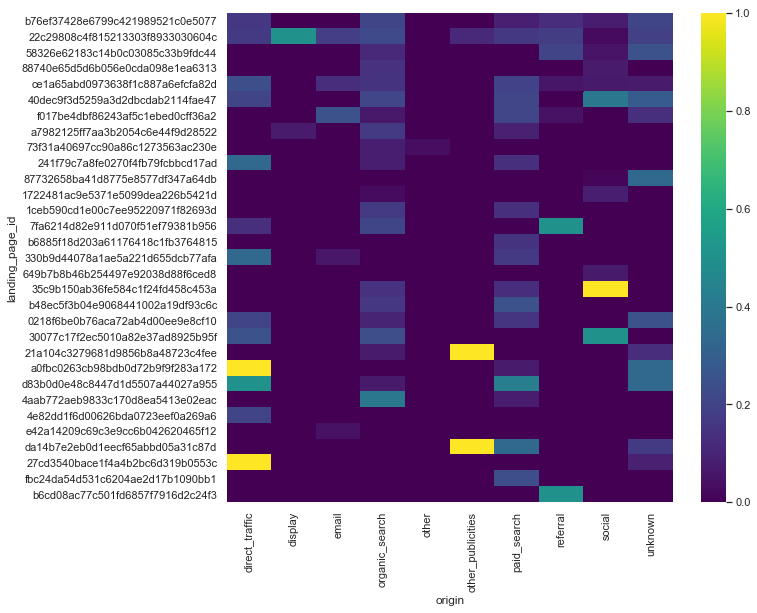

In [230]:
plt.figure(figsize=(10,9))
sns.heatmap(lead_table[origin_leaders], cmap='viridis');